In [92]:
import pandas as pd
import datetime
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn import svm
from sklearn.naive_bayes import ComplementNB
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
import pickle as pkl
!pip install shap
import shap

     |████████████████████████████████| 276kB 1.7MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-macosx_10_9_x86_64.whl size=310650 sha256=15f13b5708795410c64dc354f40fa7c8d61a4cfb673429afc09de6c9e7646436
  Stored in directory: /Users/toddhendricks/Library/Caches/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [93]:
sf = pd.read_pickle('sf_transformed.pkl')

In [94]:
features = sf.drop(columns='arrest_made')

In [79]:
X = features
y = sf.arrest_made

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [96]:
rand_forest = RandomForestClassifier(max_depth=2, random_state=46)
rand_forest.fit(X_train, y_train)
print("Random Forest Classifier Score:")
print("Training: {:6.2f}%".format(100*rand_forest.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rand_forest.score(X_test, y_test)))

Random Forest Classifier Score:
Training:  86.45%
Test set:  86.82%


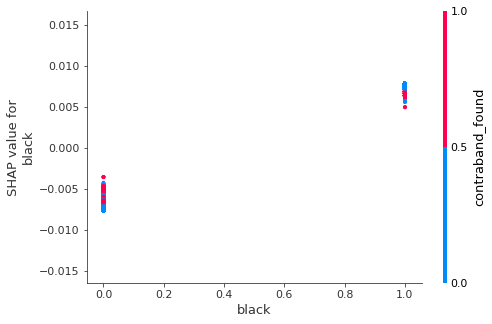

In [112]:
shap.dependence_plot("black",shap_values[0], X_train)

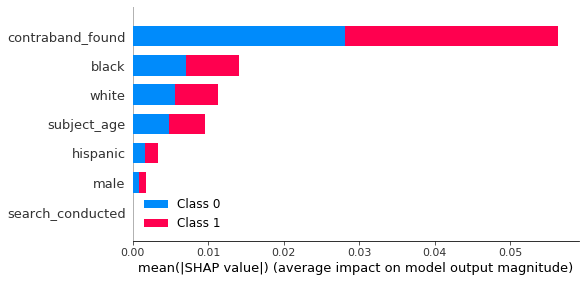

In [104]:
shap.summary_plot(shap_values, X_train)

In [22]:
comp_naive = ComplementNB()
comp_naive.fit(X_train, y_train)
print("Complement Naive Bayes Classifier Score:")
print("Training: {:6.2f}%".format(100*comp_naive.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*comp_naive.score(X_test, y_test)))

Complement Naive Bayes Classifier Score:
Training:  68.35%
Test set:  68.82%


In [24]:
log_reg = LogisticRegression(penalty='l1',random_state=0,solver='liblinear',max_iter=1000)
log_reg.fit(X_train, y_train)
print("Logistic Regression Classifier Score:")
print("Training: {:6.2f}%".format(100*log_reg.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*log_reg.score(X_test, y_test)))

Logistic Regression Classifier Score:
Training:  86.55%
Test set:  86.57%


In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
lr_confusion = confusion_matrix(y_test, log_reg.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                knn_confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     lr_confusion.flatten()/np.sum(lr_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(lr_confusion, annot=labels,fmt='' ,cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' Confusion Matrix')

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("K-Nearest Neighbors Classifier Score:")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

K-Nearest Neighbors Classifier Score:
Training:  86.08%
Test set:  84.97%


Text(0.5, 1, 'KNN Confusion Matrix')

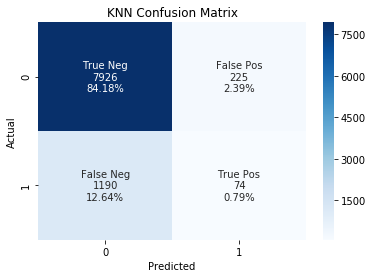

In [64]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                knn_confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     knn_confusion.flatten()/np.sum(knn_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(knn_confusion, annot=labels,fmt='' ,cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')

In [40]:
sv = svm.SVC()
sv.fit(X_train, y_train)
print("Support Vector Machines Score:")
print("Training: {:6.2f}%".format(100*sv.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*sv.score(X_test, y_test)))

Support Vector Machines Score:
Training:  86.55%
Test set:  86.57%
